# Decision Tree Implementation in Python
**In this notebook, we are considering a bank marketing dataset downloaded from <a href="https://www.kaggle.com/rouseguy/bankbalanced">Kaggle</a>.  The aim is to predict whether a customer will subscribe to a term deposit (yes/no) by building a Decision Tree Classifier.**

In [1]:
#Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Reading and Exploring the Data

In [2]:
data = pd.read_csv('bankbalanced/bank.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
data.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [5]:
data['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

In [6]:
data['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [7]:
data['education'].unique()

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

In [8]:
data['default'].unique()

array(['no', 'yes'], dtype=object)

In [9]:
data['housing'].unique()

array(['yes', 'no'], dtype=object)

In [10]:
data['loan'].unique()

array(['no', 'yes'], dtype=object)

In [11]:
data['contact'].unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [12]:
data['campaign'].unique()

array([ 1,  2,  3,  4,  6,  5,  8, 11,  9, 10, 15, 12, 14,  7, 24, 13, 17,
       29, 21, 20, 16, 32, 19, 25, 22, 43, 18, 41, 63, 27, 30, 26, 23, 28,
       33, 31], dtype=int64)

In [13]:
data['previous'].unique()

array([ 0,  1,  4,  2,  3, 10,  7,  9,  5, 29,  6, 13, 17,  8, 11, 30, 22,
       58, 21, 14, 26, 12, 19, 55, 23, 15, 20, 27, 16, 41, 40, 28, 18, 37],
      dtype=int64)

In [14]:
data['poutcome'].unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

<h2>Dealing with categorical variables</h2>

In [15]:
data_copy = data.copy()

In [16]:
#Combine similar jobs into single category
data_copy['job'] = data_copy['job'].replace(['management','admin.'],'whitecollar')
data_copy['job'] = data_copy['job'].replace(['technician','housemaid','services'],'services')
data_copy['job'] = data_copy['job'].replace(['retired','student','unemployed','unknown'],'other')

In [17]:
data_copy['job'].unique()

array(['whitecollar', 'services', 'other', 'blue-collar', 'entrepreneur',
       'self-employed'], dtype=object)

In [18]:
data_copy['poutcome'] = data_copy['poutcome'].replace(['unknown','other'],'other')

In [19]:
data_copy['poutcome'].unique()

array(['other', 'failure', 'success'], dtype=object)

In [20]:
#We can drop the contact column as every person has to be contacted and this doesn't affect the final outcome in any way
data_copy.drop(['contact'],axis=1,inplace=True)

In [21]:
#The columns: - [default,housing,loan,deposit] are having just two categories Yes/No. Hence, we can map them as Yes=1, No=0
data_copy['default'] = data_copy['default'].map({'yes':1,'no':0})
data_copy['housing'] = data_copy['housing'].map({'yes':1,'no':0})
data_copy['loan'] = data_copy['loan'].map({'yes':1,'no':0})
data_copy['deposit'] = data_copy['deposit'].map({'yes':1,'no':0})

In [22]:
#The columns: month and day have no specific effect on the target variable, hence we can drop these two columns
data_copy.drop(['month','day'],axis=1,inplace=True)

In [23]:
#len(data_copy[data_copy['pdays']==-1]) -> 8324
#pdays=-1 means that the person has not been contacted. Since, more than 70% of customers have not been contacted, the attribute of pdays can not be of much significance.
data_copy.drop(['pdays'],axis=1,inplace=True)

In [24]:
data_copy.head()

age          job  marital  education  default  balance  housing  loan  \
0   59  whitecollar  married  secondary        0     2343        1     0   
1   56  whitecollar  married  secondary        0       45        0     0   
2   41     services  married  secondary        0     1270        1     0   
3   55     services  married  secondary        0     2476        1     0   
4   54  whitecollar  married   tertiary        0      184        0     0   

   duration  campaign  previous poutcome  deposit  
0      1042         1         0    other        1  
1      1467         1         0    other        1  
2      1389         1         0    other        1  
3       579         1         0    other        1  
4       673         2         0    other        1

<h2>Converting to dummy variables</h2>

In [25]:
jobs = pd.get_dummies(data_copy['job'],drop_first=True)
marital = pd.get_dummies(data_copy['marital'],drop_first=True)
education = pd.get_dummies(data_copy['education'],drop_first=True)
poutcome = pd.get_dummies(data_copy['poutcome'],drop_first=True)

In [26]:
data_copy.drop(['job','marital','education','poutcome'],axis=1,inplace=True)

In [27]:
data_copy = pd.concat([data_copy,jobs,marital,education,poutcome],axis=1)

In [28]:
data_copy.head()

age  default  balance  housing  loan  duration  campaign  previous  \
0   59        0     2343        1     0      1042         1         0   
1   56        0       45        0     0      1467         1         0   
2   41        0     1270        1     0      1389         1         0   
3   55        0     2476        1     0       579         1         0   
4   54        0      184        0     0       673         2         0   

   deposit  entrepreneur  ...  self-employed  services  whitecollar  married  \
0        1             0  ...              0         0            1        1   
1        1             0  ...              0         0            1        1   
2        1             0  ...              0         1            0        1   
3        1             0  ...              0         1            0        1   
4        1             0  ...              0         0            1        1   

   single  secondary  tertiary  unknown  other  success  
0       0          1         0        0      1        0  
1       0          1         0        0      1        0  
2       0          1         0        0      1        0  
3       0          1         0        0      1        0  
4       0          0         1        0      1        0  

[5 rows x 21 columns]

Now, the data is compatible for use with sklearn.

# Analyzing the data

In [29]:
data = data_copy

In [30]:
data.corr()

age   default   balance   housing      loan  duration  \
age            1.000000 -0.011425  0.112300 -0.168700 -0.031418  0.000189   
default       -0.011425  1.000000 -0.060954  0.011076  0.076434 -0.009760   
balance        0.112300 -0.060954  1.000000 -0.077092 -0.084589  0.022436   
housing       -0.168700  0.011076 -0.077092  1.000000  0.076761  0.035051   
loan          -0.031418  0.076434 -0.084589  0.076761  1.000000 -0.001914   
duration       0.000189 -0.009760  0.022436  0.035051 -0.001914  1.000000   
campaign      -0.005278  0.030975 -0.013894  0.006660  0.034722 -0.041557   
previous       0.020169 -0.035273  0.030805 -0.000840 -0.022668 -0.026716   
deposit        0.034901 -0.040680  0.081129 -0.203888 -0.110580  0.451919   
entrepreneur   0.024176  0.022060  0.005039  0.011492  0.042631 -0.000908   
other          0.296418 -0.018130  0.050744 -0.233309 -0.096196  0.010680   
self-employed -0.023163  0.007493  0.020264 -0.016903  0.004299  0.013506   
services      -0.088290 -0.002409 -0.025437  0.036016  0.016137 -0.004965   
whitecollar   -0.080122 -0.013425  0.013780 -0.012111 -0.007871 -0.031980   
married        0.318436 -0.006819  0.025431  0.036305  0.044148 -0.036179   
single        -0.467799 -0.006255 -0.014994 -0.043817 -0.065288  0.023847   
secondary     -0.094400 -0.000618 -0.070609  0.118514  0.079583  0.003820   
tertiary      -0.101372 -0.011768  0.069128 -0.114955 -0.067513 -0.006813   
unknown        0.077761  0.005421  0.014596 -0.053191 -0.050249 -0.015887   
other         -0.038992  0.048403 -0.034524  0.031375  0.053686  0.042725   
success        0.062114 -0.040272  0.045603 -0.136299 -0.080370 -0.022578   

               campaign  previous   deposit  entrepreneur  ...  self-employed  \
age           -0.005278  0.020169  0.034901      0.024176  ...      -0.023163   
default        0.030975 -0.035273 -0.040680      0.022060  ...       0.007493   
balance       -0.013894  0.030805  0.081129      0.005039  ...       0.020264   
housing        0.006660 -0.000840 -0.203888      0.011492  ...      -0.016903   
loan           0.034722 -0.022668 -0.110580      0.042631  ...       0.004299   
duration      -0.041557 -0.026716  0.451919     -0.000908  ...       0.013506   
campaign       1.000000 -0.049699 -0.128081      0.013883  ...       0.001776   
previous      -0.049699  1.000000  0.139867     -0.022470  ...      -0.002338   
deposit       -0.128081  0.139867  1.000000     -0.034443  ...      -0.004707   
entrepreneur   0.013883 -0.022470 -0.034443      1.000000  ...      -0.033762   
other         -0.050212  0.031191  0.144408     -0.070264  ...      -0.078356   
self-employed  0.001776 -0.002338 -0.004707     -0.033762  ...       1.000000   
services       0.026417 -0.018242 -0.045637     -0.105969  ...      -0.118173   
whitecollar    0.001944  0.034929  0.031621     -0.127511  ...      -0.142196   
married        0.047722 -0.005176 -0.092157      0.050746  ...      -0.008164   
single        -0.046165  0.023817  0.094632     -0.058665  ...       0.016864   
secondary     -0.013834 -0.004620 -0.051952     -0.021132  ...      -0.060080   
tertiary      -0.005427  0.028146  0.094598      0.026612  ...       0.097929   
unknown        0.012976 -0.011898  0.014355     -0.001555  ...      -0.016336   
other          0.128907 -0.496921 -0.224785      0.026966  ...       0.008786   
success       -0.091807  0.325477  0.286642     -0.035072  ...      -0.001399   

               services  whitecollar   married    single  secondary  tertiary  \
age           -0.088290    -0.080122  0.318436 -0.467799  -0.094400 -0.101372   
default       -0.002409    -0.013425 -0.006819 -0.006255  -0.000618 -0.011768   
balance       -0.025437     0.013780  0.025431 -0.014994  -0.070609  0.069128   
housing        0.036016    -0.012111  0.036305 -0.043817   0.118514 -0.114955   
loan           0.016137    -0.007871  0.044148 -0.065288   0.079583 -0.067513   
duration      -0.004965    -0.031980 -0.036179  0.023847

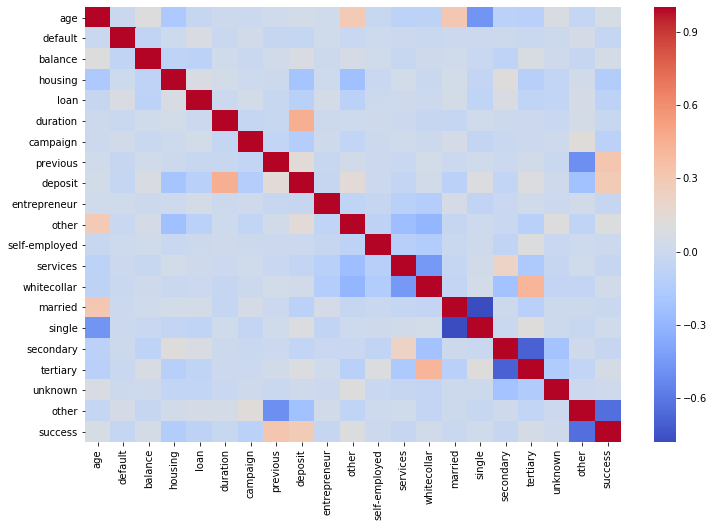

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),cmap='coolwarm')

We can see from the above heatmap that the most correlated attribute to deposit is duration.

# Slicing the data into training and testing set

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X = data.drop(['deposit'],axis=1)
y = data['deposit']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

# Building the decision tree classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import classification_report,confusion_matrix

**I. Building model with gini index criterion**

In [35]:
dtree_gini = DecisionTreeClassifier(criterion='gini',max_depth=3)

In [36]:
dtree_gini.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
dtree_gini.score(X_test,y_test)

0.7691848312929233

In [38]:
#In order to tune the max-depth of out model, we will test the model for different values of max_depth
scores = []
for i in range(3,13):
    dtree_test = DecisionTreeClassifier(criterion='gini',max_depth=i)
    dtree_test.fit(X_train,y_train)
    scores.append(dtree_test.score(X_test,y_test))
print(scores)

[0.7691848312929233, 0.7691848312929233, 0.7903851896088384, 0.7933711555688265, 0.7951627351448194, 0.8011346670647954, 0.7969543147208121, 0.795759928336817, 0.7859062406688564, 0.775753956404897]


From the above scores list, we can see that the maximum accuracy is obtained at max-depth=8 and then it starts decreasing. 
Hence, we take max-depth = 8 and again train our model for this depth

In [39]:
dtree_gini = DecisionTreeClassifier(criterion='gini',max_depth=8)
dtree_gini.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [40]:
predictions_gini = dtree_gini.predict(X_test)

In [41]:
print("Confusion Matrix for Decision Tree with Gini-Index criterion:\n",confusion_matrix(y_test,predictions_gini))
print("\n\nClassification Report:\n",classification_report(y_test,predictions_gini))

Confusion Matrix for Decision Tree with Gini-Index criterion:
 [[1461  300]
 [ 368 1220]]


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81      1761
           1       0.80      0.77      0.79      1588

    accuracy                           0.80      3349
   macro avg       0.80      0.80      0.80      3349
weighted avg       0.80      0.80      0.80      3349



In [42]:
print("Training Score: ",dtree_gini.score(X_train,y_train))
print("Test Score: ",dtree_gini.score(X_test,y_test))

Training Score:  0.8297708946627416
Test Score:  0.8005374738727978


This shows that the accuracy obtained by using gini-index criteria is 80.05%

In [43]:
accuracy_gini = dtree_gini.score(X_test,y_test)

**II. Building model with information gain criterion**

In [44]:
#We again loop over different values to find optimal max-depth
scores = []
for i in range(3,13):
    dtree_test = DecisionTreeClassifier(criterion='entropy',max_depth=i)
    dtree_test.fit(X_train,y_train)
    scores.append(dtree_test.score(X_test,y_test))
print(scores)

[0.7691848312929233, 0.7691848312929233, 0.7900865930128397, 0.7933711555688265, 0.7975515079128098, 0.8005374738727978, 0.7969543147208121, 0.792773962376829, 0.7945655419528217, 0.7841146610928635]


From this, again the optimal value if 8.

In [45]:
dtree_ig = DecisionTreeClassifier(criterion='entropy',max_depth=8)
dtree_ig.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [46]:
predictions_ig = dtree_ig.predict(X_test)

In [47]:
print("Confusion Matrix for Decision Tree with Gini-Index criterion:\n",confusion_matrix(y_test,predictions_ig))
print("\n\nClassification Report:\n",classification_report(y_test,predictions_ig))

Confusion Matrix for Decision Tree with Gini-Index criterion:
 [[1449  312]
 [ 357 1231]]


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1761
           1       0.80      0.78      0.79      1588

    accuracy                           0.80      3349
   macro avg       0.80      0.80      0.80      3349
weighted avg       0.80      0.80      0.80      3349



In [48]:
print("Training Score: ",dtree_ig.score(X_train,y_train))
print("Test Score: ",dtree_ig.score(X_test,y_test))

Training Score:  0.8268270830666837
Test Score:  0.8002388772767991


This shows that the accuracy obtained by using information gain criteria is 80.02%

In [49]:
accuracy_ig = dtree_ig.score(X_test,y_test)

# Plotting the decision trees

In [50]:
plt.figure(figsize=(500,40))
gini_tree = plot_tree(dtree_gini,feature_names=X.columns,class_names=["Yes","No"],filled=True,rounded=True,fontsize=14)
#Double click on the image to zoom it

In [51]:
plt.figure(figsize=(500,40))
ig_tree = plot_tree(dtree_ig,feature_names=X.columns,class_names=["Yes","No"],filled=True,rounded=True,fontsize=14)
#Double click on the image to zoom it

# Comparision of both the criteria

In [52]:
print("The mean accuracy of Decision Tree Classifier with Gini-Index criterion = %.2f%%"%float(accuracy_gini*100))
print("The mean accuracy of Decision Tree Classifier with Information Gain criterion = %.2f%%"%float(accuracy_ig*100))

The mean accuracy of Decision Tree Classifier with Gini-Index criterion = 80.05%
The mean accuracy of Decision Tree Classifier with Information Gain criterion = 80.02%


**Hence, we can say that both the criteria give equally accurate results for the considered data**

# <center>*----------* End of Notebook *----------*<center>